### 11. Equally Weighted Risk Contributions Portpoilo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import bt

%matplotlib inline

In [2]:
mean = np.array([0.05/252 + 0.02/252, 0.03/252 + 0.02/252])
mean


array([0.00027778, 0.00019841])

In [3]:
# 변동성
volatility = np.array([0.2/np.sqrt(252), 0.05/np.sqrt(252)])
volatility


array([0.01259882, 0.0031497 ])

In [4]:
# 분산
variance = np.power(volatility,2)
variance


array([1.58730159e-04, 9.92063492e-06])

In [6]:
np.power(np.array([2]), 2)

array([4])

In [8]:
# 상관계수
correlation = np.array(
    [
        [1, 0.25],
        [0.25,1]
    ]
)
correlation

array([[1.  , 0.25],
       [0.25, 1.  ]])

In [9]:
# 공분산
covariance = np.zeros((2,2))
covariance


array([[0., 0.],
       [0., 0.]])

In [10]:
for i in range(len(variance)):
    for j in range(len(variance)):
        covariance[i,j] = correlation[i,j]*volatility[i]*volatility[j]

covariance

array([[1.58730159e-04, 9.92063492e-06],
       [9.92063492e-06, 9.92063492e-06]])

<Axes: >

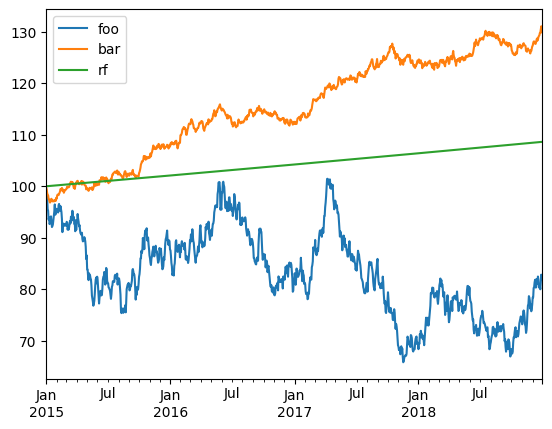

In [11]:
from pandas.tseries.offsets import BDay

names = ["foo", "bar", "rf"]
dates = pd.date_range(start="2015-01-01", end="2018-12-31", freq=BDay())
n = len(dates)
df = pd.DataFrame(np.zeros((n, len(names))), index=dates, columns=names)

np.random.seed(1)
df.loc[:, ["foo", "bar"]] = np.random.multivariate_normal(mean, covariance, size=n) # 다변량 정규분포
df["rf"] = 0.02 / 252

pdf: pd.DataFrame = 100 * np.cumprod(1 + df)
pdf.plot()

### ERC Strategy ( [pdf](http://thierry-roncalli.com/download/erc.pdf) )

In [12]:
from bt.core import Strategy
from bt.algos import RunAfterDays, SelectThese, WeighERC, Rebalance
from bt.backtest import Backtest, Result

strategy = Strategy(
    "ERC",
    algos=[
        RunAfterDays(days=20*6+1),
        SelectThese(tickers=["foo", "bar"]),
        WeighERC( # based on equal risk contribution algorithm.
            lookback=pd.DateOffset(days=20*6),
            covar_method="standard",
            risk_parity_method="slsqp",
            maximum_iterations=1000,
            tolerance=1e-9,
            lag=pd.DateOffset(days=1)
        ),
        Rebalance()

    ]
)
backtest = Backtest(strategy, pdf)
result:Result = bt.run(backtest)

/Users/heej/opt/anaconda3/envs/backtest-bt/lib/python3.11/site-packages/ffn/core.py:191: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.monthly_prices = obj.resample("M").last()  # .dropna()
/Users/heej/opt/anaconda3/envs/backtest-bt/lib/python3.11/site-packages/ffn/core.py:193: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.yearly_prices = obj.resample("A").last()  # .dropna()
/Users/heej/opt/anaconda3/envs/backtest-bt/lib/python3.11/site-packages/ffn/core.py:191: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.monthly_prices = obj.resample("M").last()  # .dropna()
/Users/heej/opt/anaconda3/envs/backtest-bt/lib/python3.11/site-packages/ffn/core.py:193: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.yearly_prices = obj.resample("A").last()  # .dropna()


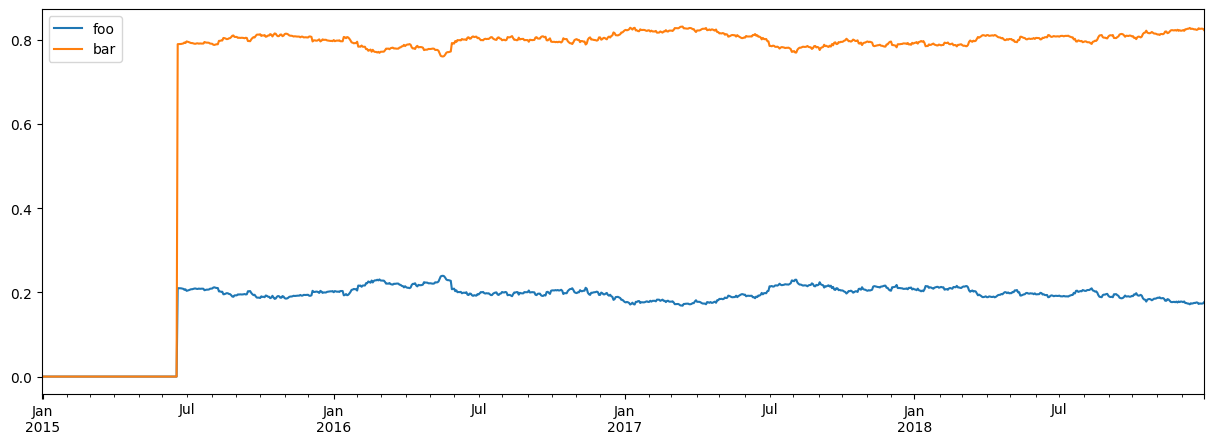

In [13]:
result.plot_security_weights()

<Axes: >

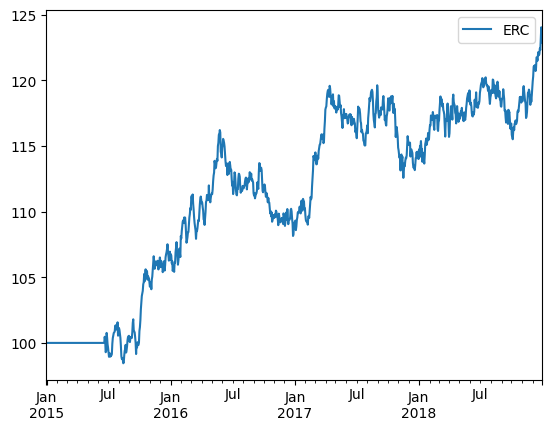

In [14]:
result.prices.plot()

### You can see the Total Risk Contribution is roughly equal from both assets.

- WeighERC 알고리즘이 equal risk contribution 인지 확인할 수 있다.

- from GPT
    - "총 위험 기여도(Total Risk Contribution)는 두 자산 모두에서 대략적으로 동일하다."
    - 즉, 포트폴리오 내에서 두 자산이 기여하는 전체 위험의 양이 비슷하다는 의미입니다. 이를 통해 포트폴리오가 균형 잡힌 위험 구조를 가지고 있다는 점을 알 수 있습니다.
    - 예를 들어, 두 자산 A와 B가 포함된 포트폴리오가 있을 때, 자산 A가 포트폴리오 전체 위험에 기여하는 정도와 자산 B가 기여하는 정도가 거의 동일하다는 뜻입니다.
    - 이 정보를 통해 투자자는 특정 자산이 포트폴리오의 위험을 과도하게 지배하지 않고, 위험이 고르게 분산되어 있다는 것을 이해할 수 있습니다.



In [36]:
# 행렬의 곱셈
np.array([[1, 0], [0, 1]]) @ np.array([[1, 0], [0, 1]])

array([[1, 0],
       [0, 1]])

[]

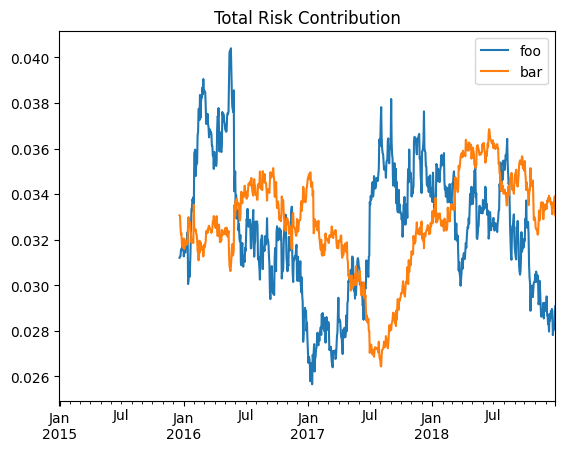

In [31]:
weights_target = result.get_security_weights().copy()
rolling_cov_target = (
    pdf.loc[:, weights_target.columns].pct_change().rolling(window=252).cov() * 252
)


trc_target = pd.DataFrame(
    np.nan, index=weights_target.index, columns=weights_target.columns
)

for dt in pdf.index:
    trc_target.loc[dt, :] = (
        weights_target.loc[dt, :].values
        * (rolling_cov_target.loc[dt, :].values @ weights_target.loc[dt, :].values)
        / np.sqrt(
            weights_target.loc[dt, :].values
            @ rolling_cov_target.loc[dt, :].values
            @ weights_target.loc[dt, :].values
        )
    )


fig, ax = plt.subplots(nrows=1, ncols=1)
trc_target.plot(ax=ax)
ax.set_title("Total Risk Contribution")
ax.plot()